In [27]:
import pandas as pd
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, accuracy_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, mean_squared_log_error
from yellowbrick.features import rank2d
import seaborn as sns 
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import numpy as np
from fitter import Fitter
import matplotlib.pyplot as plt
from  scipy.stats import iqr
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from matplotlib.pyplot import figure

figsize_width,figsize_height = 9.5, 7

plt.rcParams['figure.figsize'] = figsize_width, figsize_height
sns.set(rc={'figure.figsize':(figsize_width, figsize_height)})

pd.options.display.float_format = '{:,.2f}'.format

In [28]:
# CONSTANTS
META_FEATURES = ['GMT', 'date', 'TFL Calc', 'Inner_ID', 'file', 'VIN', 'label', 'class']
LABEL_COL = 'label'
Y_TRUE_COL = 'y_true'
Y_PRED_COL = 'y_pred'
RESIDUAL_COL = 'residual'
RESIDUAL_ABS_COL = 'residul_abs'

In [29]:
PATH = r'C:\Users\noamm\Downloads\minirocket_diagnostic_without_nans.csv'
DATES_COLS = ['datetime']

In [30]:
class model_diagnostic:
    def __init__(self, path, dates):
        self.__df = pd.read_csv(path, parse_dates=DATES_COLS)
        self.__filter = None
        self.__residual_col = None
        self.__x_cols = None
        self.__meta_features = None
    
    @property
    def df(self):
        if self.__filter:
            return self.__df[self.__df[LABEL_COL] == self.__filter]
        else:
            return self.__df
    
    @property
    def meta_features(self):
        return self.__meta_features
    
    @property
    def filter_label(self):
        return self.__filter
    
    @property
    def x_cols(self):
        return self.__x_cols
    
    @property
    def residual_col(self):
        return self.__residual_col
    
    @residual_col.setter
    def residual_col(self, value):
        self.__residual_col = value
    
    @meta_features.setter
    def meta_features(self, list_of_features):
        meta_features = [i for e in list_of_features for i in self.df.columns if e.lower() in i.lower()] 
        print("---INFO--- The meta features are {}. \n".format(meta_features))
        self.__meta_features = meta_features
        
    @filter_label.setter
    def filter_label(self, value):
        current_filter = self.__filter
        self.__filter = None
        
        if (value not in self.df[LABEL_COL].unique()) and (value != None):
            self.__filter = current_filter
            raise Exception('---ERROR --- Label {} doesnt exist. \n'.format(value))
            
        self.__filter = value  
    
    @x_cols.setter
    def x_cols(self, value):
        self.__x_cols = value
        
    def set_meta_features(self):
        self.meta_features = META_FEATURES
        
    def check_if_labels_exist(self):
        if LABEL_COL in self.df.columns:
            print("---INFO--- The following labels have been found {}, please separate the graphs accordingly. \n".format(self.df[LABEL_COL].unique().tolist()))
        else:
            raise Exception('---ERROR --- There are not labels in the data \n'.format(value))
    
    def check_if_residuals_exist(self):
        if RESIDUAL_COL not in self.df.columns:
            self.df[RESIDUAL_COL] = self.df[Y_TRUE_COL] - self.df[Y_PRED_COL]
            
        if RESIDUAL_ABS_COL not in self.df.columns:
            self.df[RESIDUAL_ABS_COL] = np.abs(self.df[RESIDUAL_COL])
            
        print('---INFO--- Both {} and {} columns exist in the data. \n'.format(RESIDUAL_COL,RESIDUAL_ABS_COL))
        
        
    def corr(self):
        rank2d(self.df[self.x_names + self.label_name])
        
    def features_bins_and_res(self, num_bins, agg_func, true_label=None, pred_label=None, qunatile_based=False):
        x_bin = []
        x_ranges = []
        cut_func = pd.qcut if qunatile_based else pd.cut
        
        for n in self.x_cols:
            x_bin.append(cut_func(self.df[n], num_bins, labels=False, duplicates='drop'))
            x_ranges.append(cut_func(self.df[n], num_bins, duplicates='drop', retbins=True)[1])
        
        x_bin = pd.concat(x_bin, axis=1)
        x_ranges = pd.DataFrame(x_ranges)
        x_ranges['names'] = self.x_cols
        x_ranges.set_index('names', inplace=True)

        x_bin['residual'] = self.df[self.residual_col]
        cond_mean = []
        for c in self.x_cols:
            cond_mean.append(x_bin.groupby(by=c)[['residual']].apply(agg_func))
           
        result = pd.concat(cond_mean, axis=1)
        result.columns = self.x_cols
        result = result.transpose()
        result.columns = [int(col) for col in result.columns]
        result = result.sort_index(axis=1)        
        sns.heatmap(result, cmap ="rocket_r", linewidths = 0.30, annot = True)
        
        way_of_bins = 'qunatiles' if qunatile_based else 'values'
        label_name = 'all' if self.filter_label == None else self.filter_label
        plt.title('{} for {} based bins for {} data'.format(agg_func.__name__, way_of_bins, label_name))
        
        return result, x_ranges
           
    def residuals_plot(self):
        fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(figsize_width*2,figsize_height*2))
        label_name = 'all' if self.filter_label == None else self.filter_label

        sns.scatterplot(data=self.df, x=Y_TRUE_COL, y=Y_PRED_COL, alpha=0.05,ax=ax[0][0])    
        ax[0][0].set_title('{} vs {} for {} data'.format(Y_TRUE_COL,Y_PRED_COL, label_name))
        
        sns.scatterplot(data=self.df, x=Y_TRUE_COL, y=RESIDUAL_COL, alpha=0.05,ax=ax[0][1])    
        ax[0][1].set_title('{} vs {} for {} data'.format(Y_TRUE_COL,RESIDUAL_COL, label_name))
        
        sns.scatterplot(data=self.df, x=Y_TRUE_COL, y=RESIDUAL_ABS_COL, alpha=0.05,ax=ax[1][0])    
        ax[1][0].set_title('{} vs {} for {} data'.format(Y_TRUE_COL,RESIDUAL_ABS_COL, label_name))
        
        sns.scatterplot(data=self.df, x=Y_PRED_COL, y=RESIDUAL_ABS_COL, alpha=0.05,ax=ax[1][1])    
        ax[1][1].set_title('{} vs {} for {} data'.format(Y_PRED_COL,RESIDUAL_ABS_COL, label_name))
        
    def r_2(self, true_label, pred_label):
        return r2(self.df[true_label], self.df[pred_label])
    
    def mape(self, true_label, pred_label):
        return mean_absolute_percentage_error(self.df[true_label], self.df[pred_label])
    
    def std(self, true_label, pred_label):
        return np.std(self.df[true_label] - self.df[pred_label])
    
    def mae(self, true_label, pred_label):
        return mean_absolute_error(self.df[true_label], self.df[pred_label])
    
    def mse(self, true_label, pred_label):
        return mean_squared_error(self.df[true_label], self.df[pred_label])

    def rmse(self, true_label, pred_label):
        return mean_squared_error(self.df[true_label], self.df[pred_label],squared=False)
    
    def rmsle(self, true_label, pred_label):
        return mean_squared_log_error(self.df[true_label], self.df[pred_label],squared=False)
    
    def std_re(self, true_label, pred_label):
        return np.std((np.abs(self.df[true_label] - self.df[pred_label]))/self.df[true_label])
    
    def fit_dist(self, dists=["norm"]):
        f = Fitter(self.df[self.residual_col].values, distributions=dists)
        f.fit()   
        
        
        dist_df = pd.DataFrame()
        dist_parmas = f.fitted_param
        for dist_type in dist_parmas.keys():
            dist_df = dist_df.join(pd.DataFrame(dist_parmas[dist_type],columns=[dist_type]),how='outer')
        
        print(dist_df)
        print('\n')
        print(pd.DataFrame(f.summary()))
        print('\n')
        
        return f,f.fitted_param,f.summary()
    
    def metrics(self, y_true, y_pred):
        dict_metrics = {}
        md.filter_label = None
        
        metrics_list = [md.mape,md.r_2,md.mae,md.mse,md.rmse,md.rmsle,md.std,md.std_re]
        
        for metric in metrics_list:
            metric_name = metric.__name__.upper()
            dict_metrics[metric_name] = {}
            dict_metrics[metric_name]['all data'] = metric(y_true, y_pred)
            for label_name in md.df[LABEL_COL].unique():
                md.filter_label = label_name
                dict_metrics[metric_name][label_name] = metric(y_true, y_pred)
                md.filter_label = None
                
        return pd.DataFrame(dict_metrics).transpose()
    
    def res_box_plot(self, return_values=False):
        res = self.df[self.residual_col].values
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(figsize_width*2,figsize_height))

        ax[0].boxplot(x=res)
        label_name = 'all' if self.filter_label == None else self.filter_label
        ax[0].set_title('Box plot for {} data'.format(label_name))
        
        ax[1].hist(x=res, bins=50)
        ax[1].set_yscale('log')
        ax[1].set_title('Histogram for {} data'.format(label_name))
        plt.show()
        
        res_iqr = iqr(res)
        outlier_plus_num = np.sum(res > np.quantile(res, 0.75) + 1.5*res_iqr )
        outlier_minus_num = np.sum(res < np.quantile(res, 0.25) - 1.5*res_iqr )
        
        print('High outliers threshold is {}'.format(np.quantile(res, 0.75) + 1.5*res_iqr)) 
        print('# of high outliers {}'.format(outlier_plus_num))
        print('Rate of high outliers {}'.format(outlier_plus_num/len(res)))
        print("---------------------------------")
        print('Low outliers threshold is {}'.format(np.quantile(res, 0.25) - 1.5*res_iqr))
        print('# of low outliers {}'.format(outlier_minus_num))
        print('Rate of high outliers {}'.format(outlier_minus_num/len(res)))
        print("---------------------------------")
        print('The IQR is {:,.3f}'.format(res_iqr))
        
        if return_values:
            return res_iqr, outlier_plus_num, outlier_minus_num
        else:
            return 
        
    def get_correlation_df(self, filtered_df, res_column, title):
        cols = self.x_cols
        corr_d = dict()
        for col in cols:
            col_corr = filtered_df[res_column].corr(self.df[col])
            corr_d[col] = [col_corr]
        corr_df = pd.DataFrame.from_dict(corr_d).transpose().abs()
        corr_df = corr_df.sort_values(by=corr_df.columns[0], ascending=False).rename(columns={0: title})
        return corr_df

    def rediauls_correlation(self):
        dict_corr = {}
        
        for res_col in [RESIDUAL_COL,RESIDUAL_ABS_COL]:
            q = self.df[res_col].quantile([.95, .05])
            top_q = q.iloc[0]
            min_q = q.iloc[1]
            low_q = self.df[res_col] < min_q
            high_q = self.df[res_col] > top_q
            low_q_corr = self.get_correlation_df(self.df[low_q], res_col, title="0.05Q_")
            high_q_corr = self.get_correlation_df(self.df[high_q], res_col, title="0.95Q_")
            dict_corr[res_col] = low_q_corr.join(high_q_corr)
            
        joined_df = pd.DataFrame(dict_corr[RESIDUAL_COL]).join(pd.DataFrame(dict_corr[RESIDUAL_ABS_COL]),lsuffix=RESIDUAL_COL,rsuffix=RESIDUAL_ABS_COL)
        sns.heatmap(joined_df, annot=True)

In [31]:
md = model_diagnostic(PATH, DATES_COLS)
md.set_meta_features()
md.x_cols = [col for col in md.df.columns if (col not in md.meta_features)]
md.check_if_labels_exist()
md.check_if_residuals_exist()
md.residual_col = RESIDUAL_ABS_COL

---INFO--- The meta features are ['datetime', 'Inner_ID_Vin', 'Inner_ID_Vin', 'label']. 

---INFO--- The following labels have been found ['normal', 'anomaly'], please separate the graphs accordingly. 

---INFO--- Both residual and residul_abs columns exist in the data. 



In [32]:
md.filter_label = 'normal'

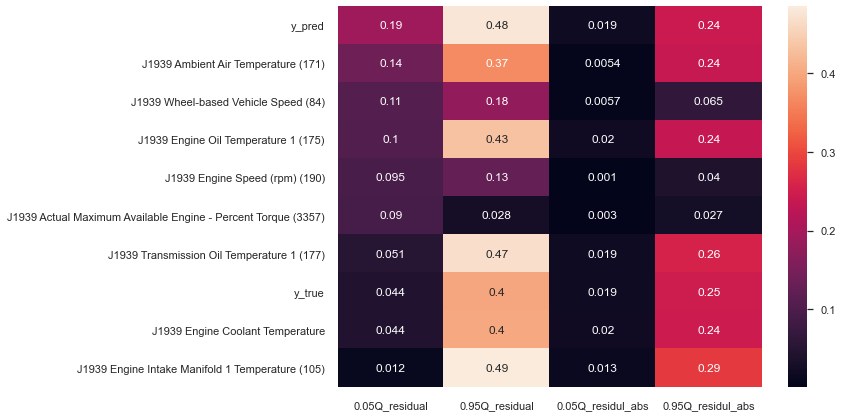

In [33]:
md.rediauls_correlation()

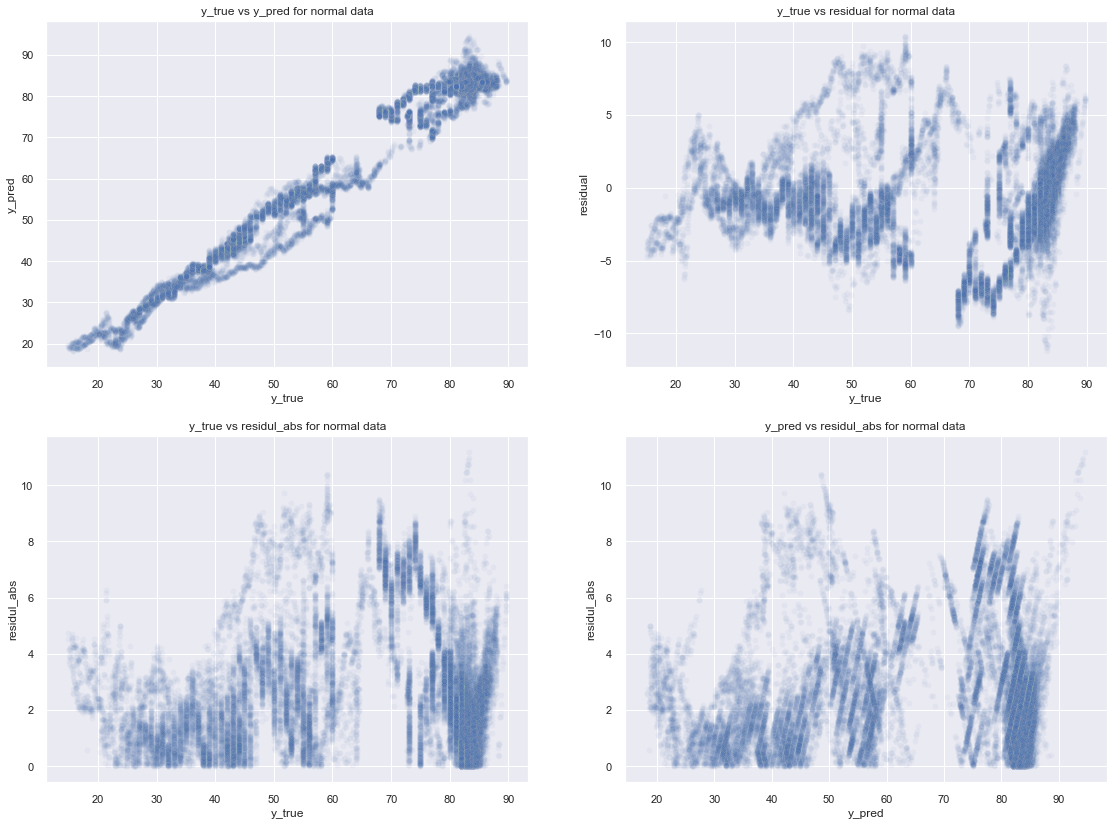

In [34]:
md.residuals_plot()

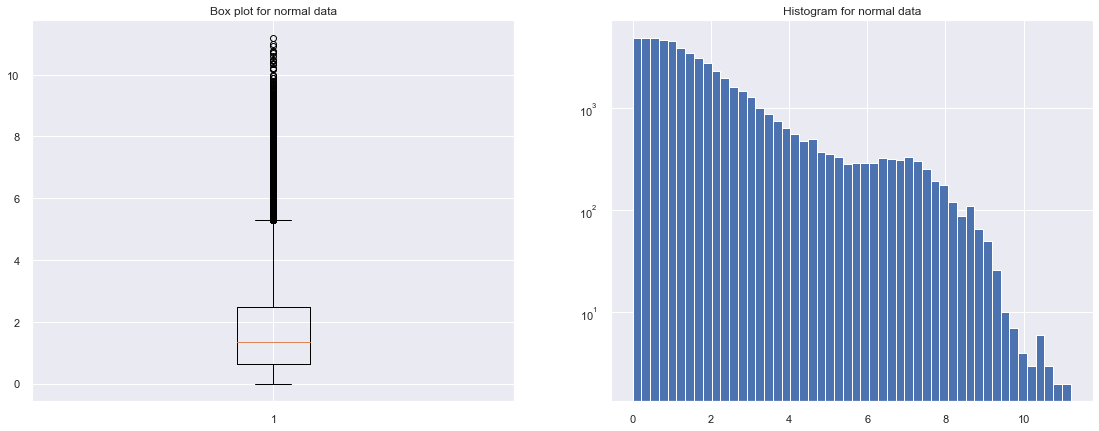

High outliers threshold is 5.282892467125407
# of high outliers 4022
Rate of high outliers 0.07190231867994351
---------------------------------
Low outliers threshold is -2.1553319950834293
# of low outliers 0
Rate of high outliers 0.0
---------------------------------
The IQR is 1.860


In [35]:
md.res_box_plot()

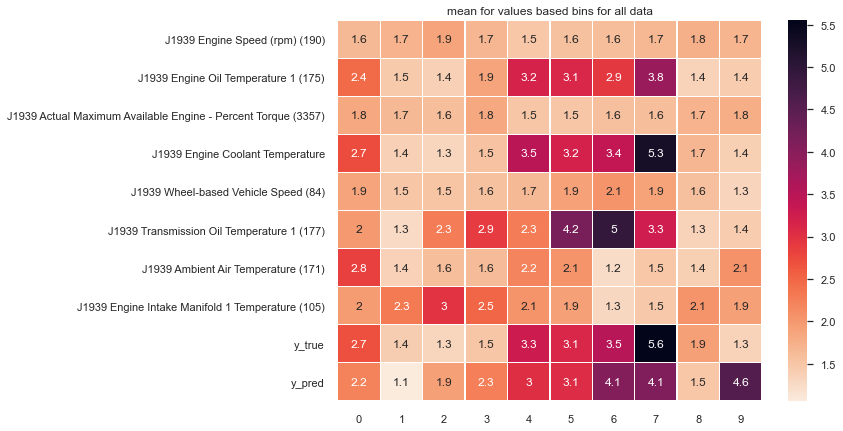

In [40]:
_, ranges = md.features_bins_and_res(10, np.mean)

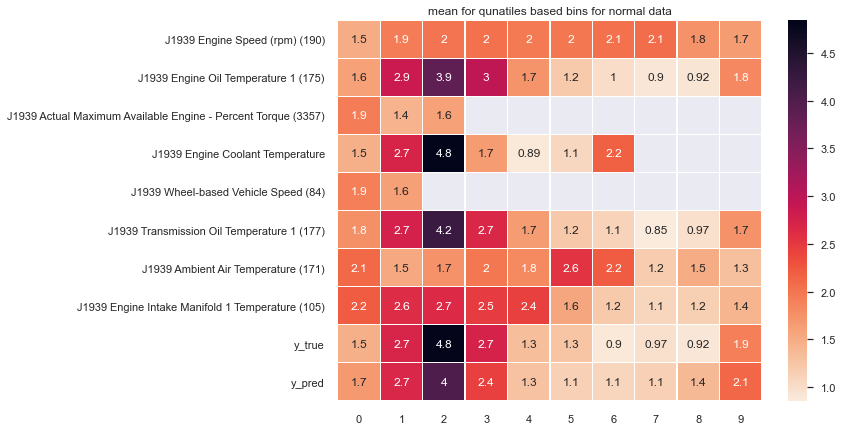

In [37]:
_, ranges = md.features_bins_and_res(10, np.mean, qunatile_based=True)

In [38]:
md.metrics(Y_TRUE_COL, Y_PRED_COL)

,all data,normal,anomaly
MAPE,0.03,0.03,0.02
R_2,0.97,0.98,0.37
MAE,1.76,1.90,1.59
MSE,5.77,6.88,4.35
RMSE,2.40,2.62,2.09
RMSLE,0.04,0.04,0.03
STD,2.37,2.51,2.08
STD_RE,0.03,0.03,0.02


   gamma
0   1.15
1  -0.00
2   1.53


       sumsquare_error    aic           bic  kl_div
gamma             0.01 779.65 -1,603,642.06    0.01




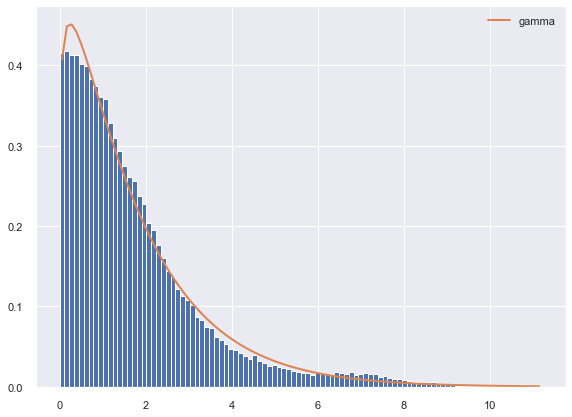

In [39]:
f, dist_params, dist_summaries = md.fit_dist(['gamma'])